In [3]:
import multiprocessing as mp

import aesara
import aesara.tensor as at
import arviz as az
import numpy as np
import pymc as pm

from hssm.wfpt.wfpt import WFPT
from hssm.wfpt.lan import LAN
import ssms.basic_simulators

In [2]:
logp, logp_grad, logp_nojit = LAN.make_jax_logp_funcs_from_onnx("test.onnx", n_params=5)

In [4]:
logp_aesara = LAN.make_aesara_logp("test.onnx")

In [5]:
logp_aesara(np.ones(1000), *([1.0] * 5))

Sum{acc_dtype=float64}.0

In [7]:
logp_aesara(np.ones(1000), *([1.0] * 5)).eval()

array(3887.73633209)

In [3]:
logp(np.ones(1000), *([1.0] * 5))
logp_grad(np.ones(1000), *([1.0] * 5))

(DeviceArray(300.39628854, dtype=float64, weak_type=True),
 DeviceArray(-626.80957384, dtype=float64, weak_type=True),
 DeviceArray(17390.32921241, dtype=float64, weak_type=True),
 DeviceArray(-137150.44377326, dtype=float64, weak_type=True),
 DeviceArray(1115.6818593, dtype=float64, weak_type=True))

In [4]:
logp_op = LAN.make_jax_logp_ops(logp, logp_grad, logp_nojit)

In [5]:
logp_op(np.ones(1000), *([1.0] * 5)).eval()

array(3887.73633209)

In [8]:
v_1 = at.as_tensor_variable(1.0)
x = logp_op(np.ones(10), *[v_1, 1.0, 1.0, 1.0, 1.0])
aesara.grad(x, wrt=v_1).eval()

In [7]:
LAN = WFPT.make_lan_distribution(
    model="test.onnx",
    backend="jax",
    list_params=["v", "a", "z", "t", "theta"],
)

In [4]:
LAN_aesara = WFPT.make_lan_distribution(
    model="test.onnx",
    backend="aesara",
    list_params=["v", "a", "z", "t", "theta"],
)

In [5]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)

In [6]:
# Basic expressive example of a corresponding PyMC model:
with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    rt = LAN_aesara(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    trace_angle_nuts = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx=mp.get_context("forkserver")
    )

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, a, z, t, theta]
INFO:pymc:NUTS: [v, a, z, t, theta]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 328 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 328 seconds.


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

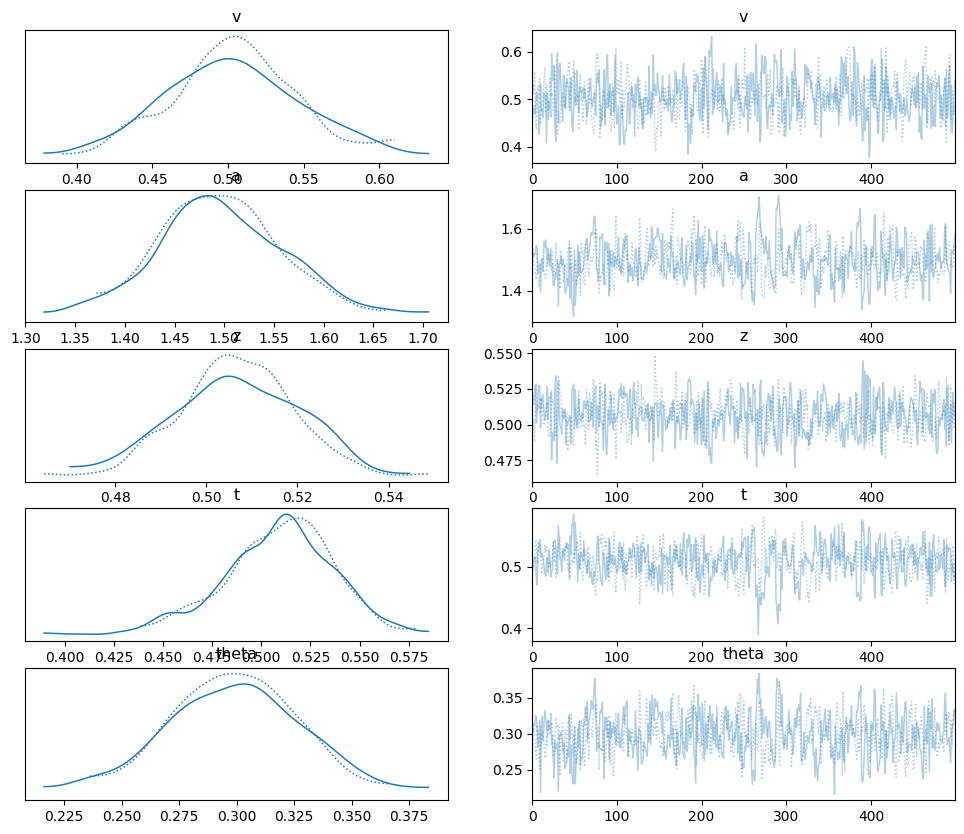

In [13]:
az.plot_trace(trace_angle_nuts)

array([[<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'t'}>,
        <AxesSubplot:title={'center':'t'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

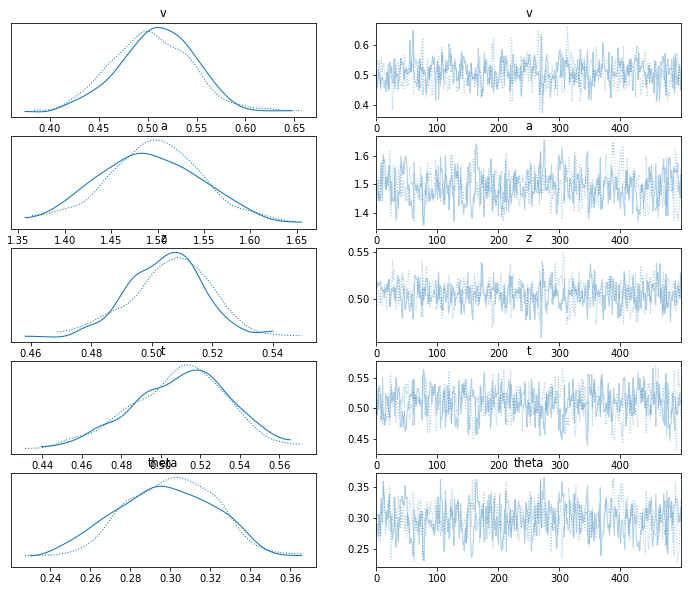

In [7]:
az.plot_trace(trace_angle_nuts)

In [ ]:
# Basic expressive example of a corresponding PyMC model:
with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    rt = LAN(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0],
    )

    trace_angle_nuts = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx=mp.get_context("forkserver")
    )